In [28]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge
from sklearn.model_selection import KFold, StratifiedKFold
import warnings # to silence convergence warnings
from sklearn.metrics import mean_squared_error
import sklearn as sk
from xgboost import XGBRegressor


### Plot features

In [3]:
def plot_response_vs_inputs(csv_path):
    df = pd.read_csv(csv_path)

    response_var = "y"
    input_vars = [f"x_{i:02d}" for i in range(1, 96)]
    c_vars = [f"C_{i:02d}" for i in range(1, 6)]
    
    existing_input_vars = [col for col in input_vars if col in df.columns]
    existing_c_vars = [col for col in c_vars if col in df.columns]
    
    for var in existing_input_vars:
        df_filtered = df[[response_var, var]].dropna()
        plt.figure(figsize=(6, 4))
        plt.scatter(df_filtered[var], df_filtered[response_var], alpha=0.5)
        plt.xlabel(var)
        plt.ylabel(response_var)
        plt.title(f"{response_var} vs {var}")
        plt.grid(True)
        plt.show()

    for var in existing_c_vars:
        df_filtered = df[[response_var, var]].dropna()
        plt.figure(figsize=(6, 4))
        plt.scatter(df_filtered[var], df_filtered[response_var], alpha=0.5)
        plt.xlabel(var)
        plt.ylabel(response_var)
        plt.title(f"{response_var} vs {var}")
        plt.grid(True)
        plt.show()

#plot_response_vs_inputs("case1Data.csv")


c:\Users\Bbjar\anaconda3\envs\comp_data_analysis\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Bbjar\anaconda3\envs\comp_data_analysis\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


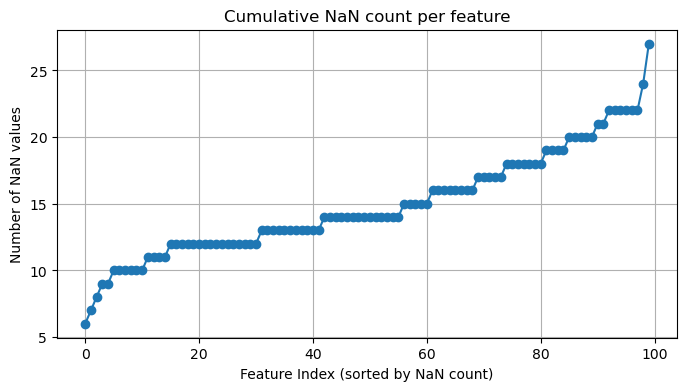

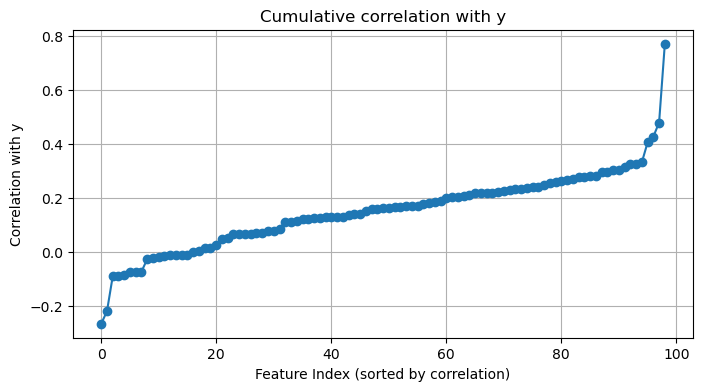

{'Mean': np.float64(211.5212379629106),
 'Std': np.float64(72.47649920974135),
 'Median': np.float64(215.25794722553087),
 'Max': np.float64(375.823073005362),
 'Min': np.float64(39.70221769951189),
 'Number of Datapoints': np.int64(100)}

In [4]:
import numpy as np

def analyze_dataset(csv_path):
    df = pd.read_csv(csv_path)

    response_var = "y"
    input_vars = [f"x_{i:02d}" for i in range(1, 96)]
    c_vars = [f"C_{i:02d}" for i in range(1, 6)]
    
    existing_vars = [col for col in input_vars + c_vars if col in df.columns]

    y_stats = {
        "Mean": df[response_var].mean(),
        "Std": df[response_var].std(),
        "Median": df[response_var].median(),
        "Max": df[response_var].max(),
        "Min": df[response_var].min(),
        "Number of Datapoints": df[response_var].count()
    }

    nan_counts = df[existing_vars].isna().sum().sort_values()
    correlation_scores = df[existing_vars].corrwith(df[response_var]).dropna().sort_values()

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(nan_counts)), nan_counts.values, marker="o")
    plt.xlabel("Feature Index (sorted by NaN count)")
    plt.ylabel("Number of NaN values")
    plt.title("Cumulative NaN count per feature")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(correlation_scores)), correlation_scores.values, marker="o")
    plt.xlabel("Feature Index (sorted by correlation)")
    plt.ylabel("Correlation with y")
    plt.title("Cumulative correlation with y")
    plt.grid(True)
    plt.show()

    return y_stats

# Example usage:
analyze_dataset("case1Data.csv")


### Describe model, model selection, validation etc.

##### Load labeled dataset

##### 1 Split into train, test, val
##### 2 Fill in missing NaN values as MEDIAN value of feature

In [5]:
#Define functions
def split_dataframe(df, train_size=75, test_size=25, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(df))
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

df = pd.read_csv("case1Data.csv")
df_filled = df.fillna(df.median())
Train, Test = split_dataframe(df_filled)

##### Load X_no_label, the 1000 datapoints without a label

In [6]:
X_no_label = pd.read_csv("case1Data_Xnew.csv")
X_no_label = X_no_label.fillna(X_no_label.median())

### PCA on X_no_label

In [7]:
### Hyperparams

n_components = 30

In [8]:
def compute_pca_transformer(X_no_label, n_components=2):    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(X_no_label)
    normalization_constants = {"mean": scaler.mean_, "std": scaler.scale_}
    
    pca = PCA(n_components=n_components)
    pca.fit(normalized_data)
    
    return pca, normalization_constants

pca, normalization_constants = compute_pca_transformer(X_no_label, n_components=n_components)

##### plot PCA 

Total variance explained by the included PCs: 0.8189


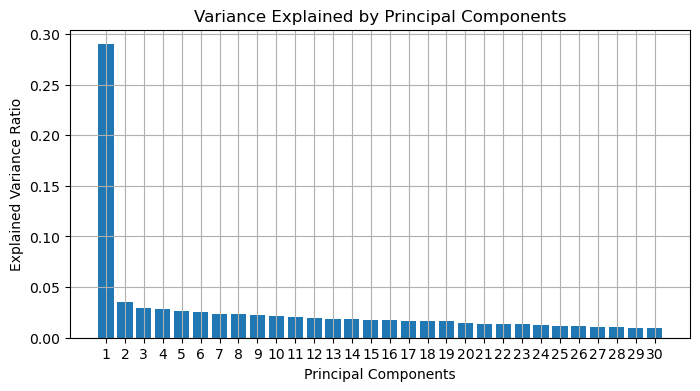

In [9]:
def plot_pca_variance(pca):
    explained_variance = pca.explained_variance_ratio_
    total_variance = np.sum(explained_variance)

    print(f"Total variance explained by the included PCs: {total_variance:.4f}")

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, 
            tick_label=[f"{i}" for i in range(1, len(explained_variance) + 1)])
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Variance Explained by Principal Components")
    plt.grid(True)
    plt.show()

    
plot_pca_variance(pca)

In [10]:
def normalize_xTrain(xTrain, normalization_constants):
    mean = normalization_constants["mean"]
    std = normalization_constants["std"]
    return (xTrain - mean) / std

def map_to_pc_space(pca, XTrain, yTrain, normalization_constants):

    xTrain_normalized = normalize_xTrain(xTrain, normalization_constants)
    xTrain_pc = pca.transform(xTrain_normalized)

    return xTrain_pc

def plot_y_against_pcs(yTrain, xTrain_pc):
    num_pcs = xTrain_pc.shape[1]
    
    for i in range(num_pcs):
        plt.figure(figsize=(6, 4))
        plt.scatter(xTrain_pc[:, i], yTrain, alpha=0.5)
        plt.xlabel(f"PC{i+1}")
        plt.ylabel("y")
        plt.title(f"y vs PC{i+1}")
        plt.grid(True)
        plt.show()


yTrain = Train["y"].values
xTrain = Train.drop(columns=["y"]).values

xTrain_pc = map_to_pc_space(pca, xTrain, yTrain, normalization_constants)

#plot_y_against_pcs(yTrain, xTrain_pc)


In [33]:
### hyperparams

lambdas = np.logspace(-2,2,10)
K = 3
seed = 69


#### Use either RAW DATA or EMBEDDED / NORMALIZED DATA

In [40]:
### USING RAW TRAIN DATA
YTrain = Train["y"].values
XTrain = Train.drop(columns=["y"]).values

### USE EMBEDDED AND NORMALIZED TRAIN DATA
YTrain = yTrain 
XTrain = xTrain_pc

CV lambda 1 std rule 12.92


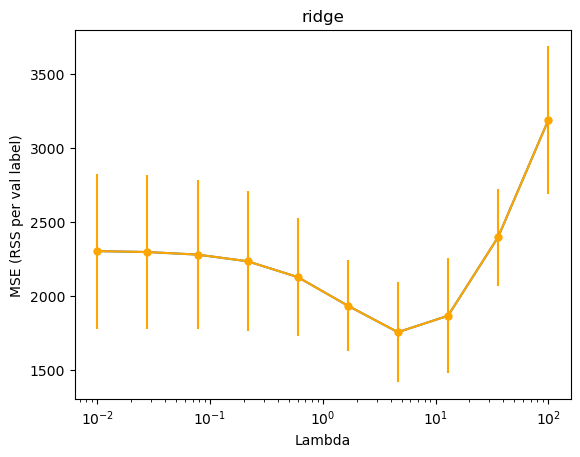

min val error is 1754.2995359458673. This is the RSS divided per datapoint in the validation set. Ie. its MSE instead of RSS.
CV lambda 1 std rule 100.00


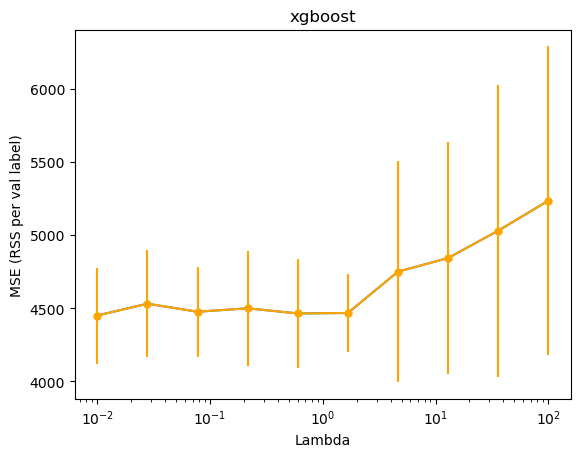

min val error is 4450.352400040329. This is the RSS divided per datapoint in the validation set. Ie. its MSE instead of RSS.


In [ ]:
def devianceFunc(ytrue, yscores):
    return np.sum((ytrue - yscores) ** 2)  # RSS equivalent

CV = KFold(n_splits=K, shuffle=True, random_state=seed)  # Use standard KFold for regression


regression_models = ["ridge", "xgboost"] #takes around 
deviance = np.zeros((len(regression_models), K, len(lambdas)))

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    #Setup CrossValidation loop
    for k, (train_index, test_index) in enumerate(CV.split(XTrain, YTrain)):

        X_train = XTrain[train_index, :]
        y_train = YTrain[train_index]
        
        y_test = YTrain[test_index]
        X_test = XTrain[test_index]

        #Setup loop over possible lambdas
        for i, lambda_ in enumerate(lambdas):
            

            for reg_i, reg_model in enumerate(regression_models):
                
                if reg_model == "ridge":
                    #For each lambda run logistic regression
                    reg = Ridge(alpha=lambda_)
                    reg.fit(X_train, y_train)
                            
                    #Predict the data in the test fold
                    yscores = reg.predict(X_test)
                    
                    RSS = devianceFunc(y_test, yscores)
                    deviance[reg_i, k, i] = RSS/y_test.shape[0]


                elif reg_model == "xgboost":
                    reg = XGBRegressor(
                        objective="reg:squarederror", 
                        reg_lambda=lambda_,  # L2 regularization (like Ridge)
                        random_state=seed,  # Ensures reproducibility
                        max_depth = 3,
                        learning_rate=0.02
                    )
                    
                    # Train the model
                    reg.fit(X_train, y_train)

                    yscores = reg.predict(X_test)

                    RSS = devianceFunc(y_test, yscores)
                    deviance[reg_i, k, i] = RSS / y_test.shape[0]  # Mean Squared Error (MSE)
                    
#Compute the average and std of the deviance over CV folds

for i in range(len(regression_models)):
    testError = np.mean(deviance[i], axis=0)  #we do across axis=0, because this axis corrosponds to the folds, meaning we average across all elements of the same column
    testStd = np.std(deviance[i], axis=0)

    #Select the optimal lambda using the 1-std-rule
    Lambda_CV_1StdRule = lambdas[testError < min(testError) +testStd][-1]
    print("CV lambda 1 std rule %0.2f" % Lambda_CV_1StdRule)

    plt.figure()
    plt.errorbar(lambdas, testError, testStd, marker='.', color='orange', markersize=10)
    plt.semilogx(lambdas, testError)

    plt.xlabel("Lambda")
    plt.ylabel("MSE (RSS per val label)")
    plt.title(f"{regression_models[i]}")
    plt.show()
    print(f"min val error is {min(testError)}. This is the RSS divided per datapoint in the validation set. Ie. its MSE instead of RSS.")

##### Handling categorical variables

### Estimate predictive performance of RSS